In [35]:
import os
import numpy as np
import seaborn as sns
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from biometrics import biometrics, plot_confusion_matrix2

from aikit.graphics.biometric_performance import performance_evaluation
from aikit.graphics.confusion_matrix import (
    plot_confusion_matrix,
    plot_system_confusion_matrix
)
from aikit.graphics.det_plot import DETPlot
from aikit.metadata import __version__ as aikit_ver
from aikit.metrics.det_curve import det_curve_pais, eer_pais
from aikit.metrics.iso_30107_3 import (
    acer,
    apcer_max,
    apcer_pais,
    bpcer,
    bpcer_ap,
    riapar
)
from aikit.metrics.scores import (
    max_error_pais_scores,
    pad_scores,
    split_attack_scores,
    split_scores
)

np.random.seed(42)

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
# load positive and negative scores
positive_scores = np.load('positive_scores_indexed.npy')
negative_scores = np.load('negative_scores_indexed.npy')

# make labels
positive_labels = np.ones(positive_scores.shape[0])
negative_labels = np.zeros(negative_scores.shape[0])

# concatenate scores and labels
scores = np.concatenate((positive_scores, negative_scores))
labels = np.concatenate((positive_labels, negative_labels))

In [37]:
positive_scores.shape, negative_scores.shape

((19029,), (105470,))

In [38]:
# normalize scores
# scores = (scores - scores.min()) / (scores.max() - scores.min())
# scores = (scores - np.min(scores))/np.ptp(scores)

In [39]:
threshold = 0.6654212811120932
y_true = labels
y_score = 1 - scores # scores are inverted because they are distances
y_pred = np.array([1 if s > threshold else 0 for s in y_score])

Imposter EER: 0.2154331633844181
Imposter EER Threshold: 0.6654212811120932



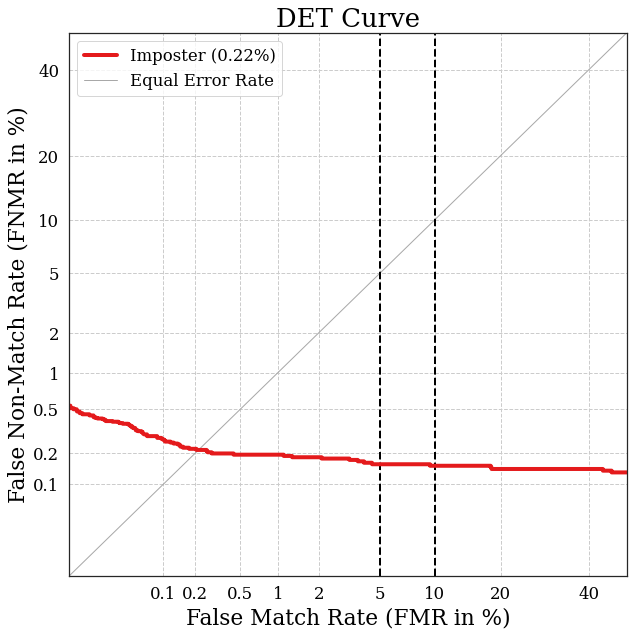

In [40]:
_no_bf = 0
_bf_index = 1
_classes = ['Imposter', 'Bonafide']
det = DETPlot(context="notebook", xlabel="False Match Rate (FMR in %)", ylabel="False Non-Match Rate (FNMR in %)")

bonafide_scores = y_score[ y_true == _bf_index ]
attack_scores = y_score[ y_true == _no_bf ]
det.set_system(attack_scores, bonafide_scores, label=f"{_classes[_no_bf]}")

det_plot = det.plot()
ths_list = list()

for system in det.systems:
    ths = det.systems[system]['eer_thres']
    ths_list.append(ths)
    eer = det.systems[system]['eer']
    print(f'{system} EER: {eer}')
    print(f'{system} EER Threshold: {ths}\n')

In [41]:
threshold = max(ths_list)
attack_scores, bonafide_scores, attack_true, bonafide_true = split_scores(y_true, y_score, bonafide_label=_bf_index)
pais_attack_scores = split_attack_scores(attack_true, attack_scores)

det_pais = det_curve_pais(attack_true, attack_scores, bonafide_scores)
eer_pais_ = eer_pais(det_pais, percentage=True)

max_eer_pais = int(max(eer_pais_, key=eer_pais_.get))
max_attack_scores, max_attack_pais = max_error_pais_scores(attack_true, attack_scores, threshold=threshold)

acer_ = acer(attack_true, attack_scores, bonafide_scores, threshold=threshold)
apcer_ = apcer_pais(attack_true, attack_scores, threshold=threshold, percentage=True)
bpcer_ = bpcer(bonafide_scores, threshold=threshold)
bpcer10, bpcer10thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 10, percentage=True)
bpcer20, bpcer20thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 20, percentage=True)
bpcer50, bpcer50thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 50, percentage=True)
bpcer100, bpcer100thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 100, percentage=True)
bpcer200, bpcer200thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 200, percentage=True)
bpcer500, bpcer500thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 500, percentage=True)
bpcer1000, bpcer1000thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 1000, percentage=True)
bpcer10000, bpcer10000thres = bpcer_ap(det_pais[max_eer_pais][0], det_pais[max_eer_pais][1], det_pais[max_eer_pais][2], 10000, percentage=True)
riapar_ = riapar(max_attack_scores, bonafide_scores, attack_threshold=threshold, bonafide_threshold=threshold)

print(
    f"        Bona Fide label: {_bf_index}: {_classes[_bf_index]}\n"
    f"            Threshold t: {threshold}\n"
    "--------------------------------------------\n"
    f"           Max EER PAIS: {max_eer_pais}: {_classes[max_eer_pais]}\n"
    f"                 EER[{max_eer_pais}]: {eer_pais_[max_eer_pais][0]}%\n"
    f"       EER threshold[{max_eer_pais}]: {eer_pais_[max_eer_pais][1]}\n"
    "--------------------------------------------\n"
    f"      Max APCER PAIS(t): {max_attack_pais}: {_classes[max_attack_pais]}\n"
    f"                ACER(t): {acer_*100}%\n"
    f"               APCER(t): {apcer_}%\n"
    f"               BPCER(t): {bpcer_*100}%\n"
    f"              RIAPAR(t): {riapar_*100}%\n"
    f"                 EER[{max_attack_pais}]: {eer_pais_[max_attack_pais][0]}%\n"
    f"       EER threshold[{max_attack_pais}]: {eer_pais_[max_attack_pais][1]}\n"
    "--------------------------------------------\n"
    f"   BPCER10(APCER=10.0%): {bpcer10}%, {bpcer10thres}\n"
    f"   BPCER20(APCER=5.00%): {bpcer20}%, {bpcer20thres}\n"
    f"   BPCER50(APCER=2.00%): {bpcer50}%, {bpcer50thres}\n"
    f"  BPCER100(APCER=1.00%): {bpcer100}%, {bpcer100thres}\n"
    f"   BPCER200(APCER=0.50%): {bpcer200}%, {bpcer200thres}\n"
    f"   BPCER500(APCER=0.20%): {bpcer500}%, {bpcer500thres}\n"
    f" BPCER1000(APCER=0.10%): {bpcer1000}%, {bpcer1000thres}\n"
    f"BPCER10000(APCER=0.01%): {bpcer10000}%, {bpcer10000thres}\n"
)

        Bona Fide label: 1: Bonafide
            Threshold t: 0.6654212811120932
--------------------------------------------
           Max EER PAIS: 0: Imposter
                 EER[0]: 0.21539554294754548%
       EER threshold[0]: 0.665466281112093
--------------------------------------------
      Max APCER PAIS(t): 0: Imposter
                ACER(t): 0.2153438457695697%
               APCER(t): {0.0: 0.21522707879017727}%
               BPCER(t): 0.2154606127489621%
              RIAPAR(t): 0.43068769153914443%
                 EER[0]: 0.21539554294754548%
       EER threshold[0]: 0.665466281112093
--------------------------------------------
   BPCER10(APCER=10.0%): 0.1523989699931727%, 0.6175762811123109
   BPCER20(APCER=5.00%): 0.15765410688948212%, 0.629431281112257
   BPCER50(APCER=2.00%): 0.18392979137106247%, 0.6424762811121976
  BPCER100(APCER=1.00%): 0.1944400651636924%, 0.6511162811121582
   BPCER200(APCER=0.50%): 0.1944400651636924%, 0.6584012811121251
   BPCER500(APCE

# DB Metrics

In [42]:
biom = biometrics(positive_scores, negative_scores)

In [43]:
d_prime = biom.d_prime()
EER, EER_th = biom.get_EER()
FAR_a, FRR_a, th_a = biom.get_FRR_at(10.0)
FAR_b, FRR_b, th_b = biom.get_FRR_at(5.0)
FAR_c, FRR_c, th_c = biom.get_FRR_at(1.0)

# Print Biometric Scores
print('Biometric Scores')
print("d' = {:0.4f}".format(d_prime))
print('at EERt={:6.4f} : FMR={:6.3f}%, FNMR={:6.3f}%'.format(EER_th, EER, EER))
print('at  th={:6.4f}  : FMR={:6.3f}%, FNMR={:6.3f}%'.format(th_a, FAR_a, FRR_a))
print('at  th={:6.4f}  : FMR={:6.3f}%, FNMR={:6.3f}%'.format(th_b, FAR_b, FRR_b))
print('at  th={:6.4f}  : FMR={:6.3f}%, FNMR={:6.3f}%'.format(th_c, FAR_c, FRR_c))
print(' ')

Biometric Scores
d' = 6.3177
at EERt=0.3346 : FMR= 0.216%, FNMR= 0.216%
at  th=0.3824  : FMR=10.000%, FNMR= 0.152%
at  th=0.3706  : FMR= 4.999%, FNMR= 0.158%
at  th=0.3492  : FMR= 0.999%, FNMR= 0.194%
 


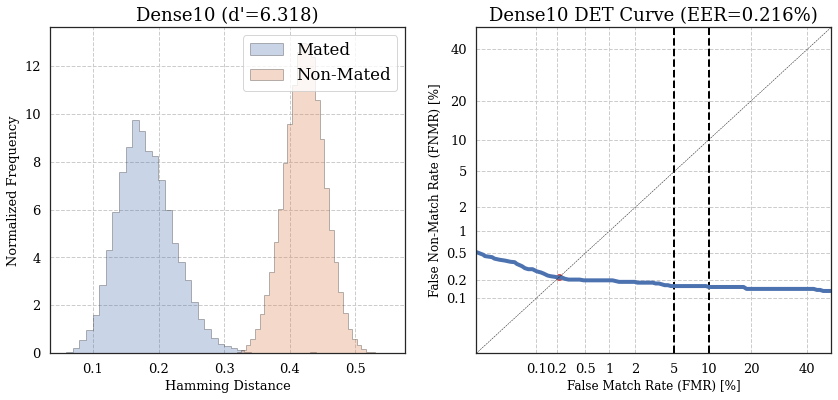

In [44]:
# Show histograms
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
kwargs = dict(histtype='stepfilled', alpha=0.3, density=True, bins=40, ec="k")
ax1.hist(positive_scores, **kwargs)
ax1.hist(negative_scores, **kwargs)
ax1.legend(['Mated','Non-Mated'])
ax1.set_title("{} (d'={:0.3f})".format('Dense10', d_prime))
ax1.set_xlabel('Hamming Distance', fontsize=13)
ax1.set_ylabel('Normalized Frequency', fontsize=13)
# plt.show()

FAR, FRR, all_th = biom.for_plots()
xylims = np.array([1e-4, 5e-1, 1e-4, 5e-1])
ticks = np.array([1e-3, 2e-3, 5e-3, 1e-2, 2e-2, 5e-2, 1e-1, 2e-1, 4e-1])
tick_labels = np.array(["0.1", "0.2", "0.5", "1", "2", "5", "10", "20", "40"])

# plot a red line at 5 and 10 percent
ax2.axvline(
    x=0.05, color="black", linewidth=2, linestyle="--"
)
ax2.axvline(
    x=0.1, color="black", linewidth=2, linestyle="--"
)
ax2.plot(FAR/100, FRR/100, label='DET')
ax2.scatter(EER/100, EER/100, c='r', label='EER')
ax2.plot(xylims[:2],xylims[:2], c='k', label='EE', linestyle='--', linewidth=0.5)
ax2.set_title("{} DET Curve (EER={:0.3f}%)".format('Dense10', EER))
ax2.set_xlabel('False Match Rate (FMR) [%]', fontsize=12)
ax2.set_ylabel('False Non-Match Rate (FNMR) [%]', fontsize=12)
ax2.set_xscale("function", functions=(norm.ppf, norm.cdf))
ax2.set_yscale("function", functions=(norm.ppf, norm.cdf))
ax2.axis(xylims)
ax2.set_xticks(ticks)
ax2.set_yticks(ticks)
ax2.set_xticklabels(tick_labels)
ax2.set_yticklabels(tick_labels)
# change the tick label size
ax1.tick_params(axis='both', which='major', labelsize=13)
ax2.tick_params(axis='both', which='major', labelsize=13)
# ax2.grid(linestyle = '--')


plt.show()

[]

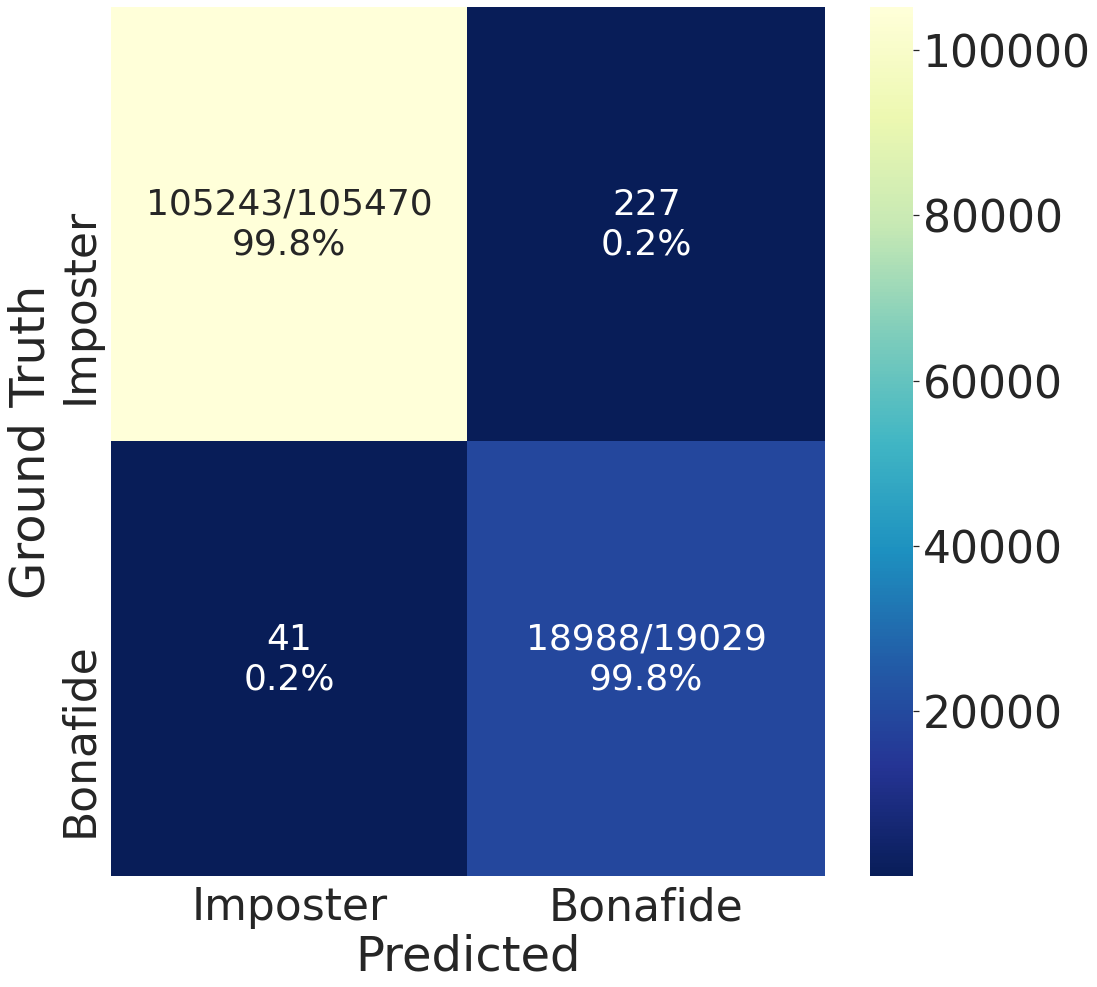

In [45]:
cm = confusion_matrix(y_true, y_pred)
fig = plot_confusion_matrix2(cm, _classes)
plt.plot()